<a href="https://colab.research.google.com/github/kdemertzis/Earthquakes/blob/main/ITSAK/latex_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt install texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35
  libjbig2dec0 libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common
  texlive-base texlive-binaries texlive-latex-base xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvis

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from numpy import asarray
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import sympy
np.set_printoptions(suppress=True)

In [3]:
# Load the earthquake dataset
data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Earthquakes/main/ITSAK/ln_1_no_titles.csv')


In [4]:
# Split the data into input and output arrays
X = data.iloc[:, :-1].values # Select all columns except the last
y = data.iloc[:, -1].values  # Select the last column as the output

In [5]:
# Scale the data
scale_X = MinMaxScaler()
X = scale_X.fit_transform(X)
scale_y = MinMaxScaler()
y = scale_y.fit_transform(y.reshape(-1,1))

In [6]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Define and run model
model = Sequential()
model.add(Dense(1, input_dim=4, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1, name='Output'))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

In [8]:
# Predict on test set
yhat = model.predict(X_test)

26/26 [==============================] - 0s 12ms/step


In [9]:
# Inverse transforms
X_plot = scale_X.inverse_transform(X_test)
y_plot = scale_y.inverse_transform(y_test)
yhat_plot = scale_y.inverse_transform(yhat)

In [10]:
# Print evaluation metrics
print("R-squared:", r2_score(y_test, yhat))
print("Mean squared error:", mean_squared_error(y_test, yhat))

R-squared: 0.8395683177162216
Mean squared error: 0.005804148249518527


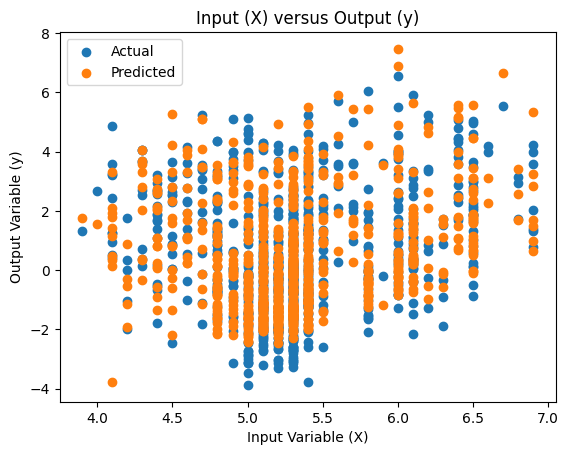

In [11]:
# Plot X_test vs y_test and yhat
plt.scatter(X_plot[:, 0], y_plot, label='Actual')
plt.scatter(X_plot[:, 0], yhat_plot, label='Predicted')
plt.title('Input (X) versus Output (y)')
plt.xlabel('Input Variable (X)')
plt.ylabel('Output Variable (y)')
plt.legend()
plt.show()

In [12]:
### Conversion to Basic Formula

# temp list as a container for each layer formulas
formula_list = []
# counter of hidden layers
f_n = 1
#
for i in range(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[i]
    W = layer.get_weights()
    # empty text string to which concatenate current layer formula parts
    formula = ''
    # set script for input layer
    if i == 0:
        for i in range(W[0].shape[1]):
            cur_weight = np.sum(W[0][0,i])
            cur_bias = np.sum(W[1][i])
            # build formula for this layer
            formula += '*'+str(np.round(cur_weight,2))+'*'+'x+'+'*'+str(np.round(cur_bias,2)) + '*'+ '/'
        # append this layer formula to temp list
        formula_list.append(formula)

    # set script for hidden layers
    elif i < len(model.layers)-1:
        # start loop for next layer each neuron
        for c in range(W[0].shape[1]):
            cur_bias = np.sum(W[1][c])
            for i in range(W[0].shape[0]):
                cur_weight = np.sum(W[0][i, c])
                # build formula for this layer using previous layer formula
                formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
            formula += '*'+str(np.round(cur_bias,2))+'*' + '/'
        # append this layer formula to temp list
        formula_list.append(formula)
        # increase index number for the next hidden layer
        f_n+=1
    # set script for output layer
    else:
        for i in range(W[0].shape[0]):
            cur_weight = np.sum(W[0][i, 0])
            # build formula for this layer using previous layer formula
            formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
        cur_bias = np.sum(W[1][0])
        formula += '*'+str(np.round(cur_bias,2))+'*'
        # append this layer formula to temp list
        formula_list.append(formula)
# get last formula
formula = formula_list[-1]
# make some cleanings
formula = formula.replace('+*-','-')
formula = formula.replace('+*0.0*','')
formula = formula.replace('-*0.0*','')
formula = formula.replace('*','')
print(formula)

-1.31f1(-0.34x-1.26)f1+0.06


In [13]:
# create LaTeX code
def latex_activation_function(x):
    return '\frac{e^{'+x+'} - e^{-'+x+'}}{e^{'+x+'} + e^{-'+x+'}}'


formula_latex = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_latex).group(1)
            start = re.search(pattern, formula_latex).start()
            formula_latex = formula_latex[:start] + latex_activation_function(substring) + formula_latex[start + 4 + len(substring):]
        except:
            exist = False

print(formula_latex)

-1.31rac{e^{(-0.34x-1.26)} - e^{-(-0.34x-1.26)}}{e^{(-0.34x-1.26)} + e^{-(-0.34x-1.26)}}+0.06


In [14]:
# Create numpy formula
def numpy_activation_function(x):
    return '(np.exp('+x+') - np.exp(-'+x+'))/(np.exp('+x+') + np.exp(-'+x+'))'


formula_numpy = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_numpy).group(1)
            start = re.search(pattern, formula_numpy).start()
            formula_numpy = formula_numpy[:start] + numpy_activation_function(substring) + formula_numpy[start + 4 + len(substring):]
        except:
            exist = False

formula_numpy = formula_numpy.replace('(np', '*(np')
formula_numpy = formula_numpy.replace('x-', '*x-')
formula_numpy = formula_numpy.replace('x+', '*x+')
formula_numpy = formula_numpy.replace('/*', '/')

print(formula_numpy)

-1.31*(np.exp((-0.34*x-1.26)) - np.exp(-(-0.34*x-1.26)))/(np.exp((-0.34*x-1.26)) + np.exp(-(-0.34*x-1.26)))+0.06


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


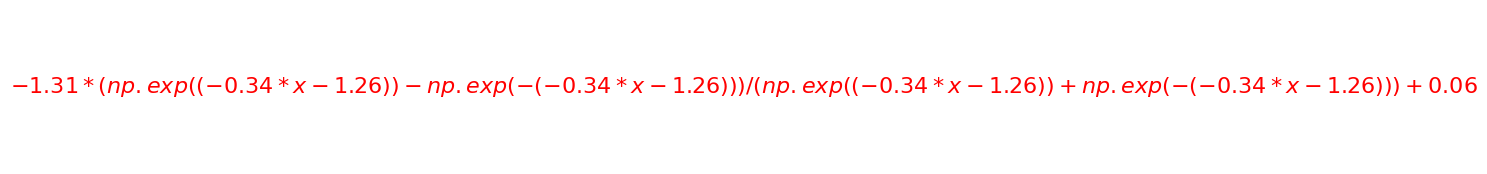

In [15]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc
rc("text", usetex=False)
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)
ax.set_axis_off()
ax.text(0.5,0.5,r'$'+formula_numpy+'$', fontsize=16, color='r', ha='center', va='center')
plt.show()

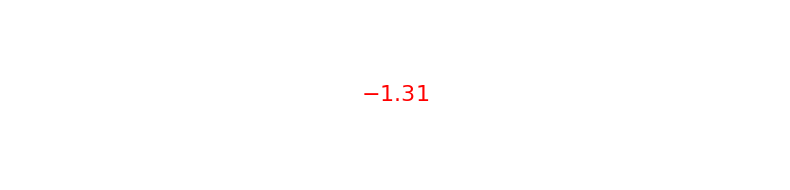

In [16]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc
rc("text", usetex=False)
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 2), tight_layout=True)
ax.set_axis_off()
ax.text(0.5,0.5,r'$'+formula_latex+'$', fontsize=16, color='r', ha='center', va='center')
plt.show()
     

In [17]:
!pip install pycaret
!pip install markupsafe==2.0.1
!pip install autoviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.5/483.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00


In [18]:
import pycaret
import jinja2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from pycaret.regression import *
# Load the earthquake dataset
data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Earthquakes/main/ITSAK/ln_1_no_titles.csv')

# Split the data into input and output arrays
X = data.iloc[:, :-1].values # Select all columns except the last
y = data.iloc[:, -1].values  # Select the last column as the output
exp_name = setup(data = X,  target = y)

,Description,Value
0,Session id,1866
1,Target,target
2,Target type,Regression
3,Original data shape,"(2717, 5)"
4,Transformed data shape,"(2717, 5)"
5,Transformed train set shape,"(1901, 5)"
6,Transformed test set shape,"(816, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [20]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5354,0.4902,0.6990,0.8851,0.2725,3.1478,0.3530
gbr,Gradient Boosting Regressor,0.5466,0.5021,0.7080,0.8821,0.2779,3.1219,0.2720
xgboost,Extreme Gradient Boosting,0.5458,0.5185,0.7176,0.8785,0.2730,4.8452,0.2920
rf,Random Forest Regressor,0.5599,0.5286,0.7263,0.8761,0.2836,2.8277,0.7250
et,Extra Trees Regressor,0.5771,0.5757,0.7579,0.8650,0.2880,2.3100,0.7040
knn,K Neighbors Regressor,0.5954,0.5908,0.7677,0.8614,0.2938,2.7917,0.0520
ada,AdaBoost Regressor,0.6541,0.6840,0.8267,0.8392,0.3224,3.0636,0.2260
br,Bayesian Ridge,0.6827,0.8140,0.8995,0.8088,0.3201,2.7996,0.0710
lar,Least Angle Regression,0.6826,0.8140,0.8995,0.8088,0.3200,2.8025,0.0910
ridge,Ridge Regression,0.6828,0.8140,0.8995,0.8088,0.3202,2.7975,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [21]:
best = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4957,0.4159,0.6449,0.9000,0.2893,1.0628
1,0.5925,0.6220,0.7887,0.8623,0.2901,1.3318
2,0.5174,0.4547,0.6743,0.8878,0.2660,1.2889
3,0.5497,0.4871,0.6979,0.8891,0.2776,2.2928
4,0.5219,0.4990,0.7064,0.8826,0.2534,0.8846
5,0.5049,0.4353,0.6598,0.8961,0.2808,16.4518
6,0.5308,0.4457,0.6676,0.8927,0.2686,0.8041
7,0.5514,0.5052,0.7107,0.8778,0.2670,4.7051
8,0.5227,0.4893,0.6995,0.8839,0.2635,1.3686


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…